In [1]:
# !pip install interpret

In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.datasets import load_breast_cancer
import warnings
random_state=42


# DATA

In [3]:
def load_breast_data():
    breast = load_breast_cancer()
    feature_names = list(breast.feature_names)
    X, y = pd.DataFrame(breast.data, columns=feature_names), breast.target
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X,
            'y': y,
            'class_names': breast.target_names
        },
    }
    return dataset, feature_names

In [4]:
dataset, feature_names = load_breast_data()
X, y, class_names = dataset['full']['X'], dataset['full']['y'], dataset['full']['class_names'] 

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=random_state)

In [6]:
train_df = X_train.copy(deep=True)
train_df ['label'] = y_train
test_df = X_test.copy(deep=True)
test_df ['label'] = y_test

In [7]:
train_df.head(n=5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
337,18.77,21.43,122.90,1092.0,0.09116,0.14020,0.10600,0.06090,0.1953,0.06083,...,34.37,161.10,1873.0,0.14980,0.48270,0.46340,0.20480,0.3679,0.09870,0
91,15.37,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.07483,0.1717,0.06097,...,25.84,107.50,830.9,0.12570,0.19970,0.28460,0.14760,0.2556,0.06828,0
270,14.29,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120,1
20,13.08,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,...,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183,1
40,13.44,21.58,86.18,563.0,0.08162,0.06031,0.03110,0.02031,0.1784,0.05587,...,30.25,102.50,787.9,0.10940,0.20430,0.20850,0.11120,0.2994,0.07146,0


# RF

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
rf.fit(X_train.values, y_train)

pred = rf.predict(X_test.values)

sklearn.metrics.f1_score(y_test, pred, average='binary')

0.9652777777777778

# XAI

In [9]:
clf_predic_proba = rf.predict_proba
id_to_explain = 7
clf_predic_proba([X_test.iloc[id_to_explain]])

array([[0.85, 0.15]])

## LIME

In [10]:
# https://vishesh-gupta.medium.com/understanding-your-model-with-lime-d7704d984696

In [11]:
import lime
import lime.lime_tabular

In [12]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values[:,:], feature_names = feature_names, class_names=class_names,
                                                   categorical_features=None,
                                                   categorical_names=None,discretizer='decile',kernel_width=5,discretize_continuous=True,verbose=True)

In [13]:
exp = explainer.explain_instance(X_test.iloc[id_to_explain,:], clf_predic_proba, num_features=4)

Intercept 0.6185362928143957
Prediction_local [0.36592204]
Right: 0.15


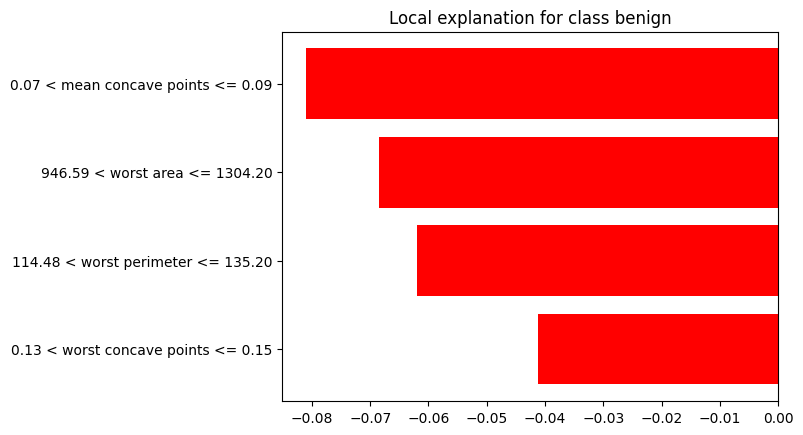

In [14]:
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)

In [15]:
exp.show_in_notebook(show_all=False)

In [16]:
pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

,Feature,Contribution
0,0.07 < mean concave points <= 0.09,-0.081066
1,946.59 < worst area <= 1304.20,-0.068448
2,114.48 < worst perimeter <= 135.20,-0.061963
3,0.13 < worst concave points <= 0.15,-0.041137


In [17]:
# Using discretize_continuous =False

In [18]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values[:,:],feature_names = feature_names,class_names=class_names,
                                                   categorical_features=None, 
                                                   categorical_names=None,kernel_width=5,discretize_continuous=False,verbose=True)

#getting the lime prediction for an observation
exp = explainer.explain_instance(X_test.iloc[id_to_explain,:],rf.predict_proba, num_features=4)

Intercept 0.49938445224909966
Prediction_local [0.39207052]
Right: 0.15


In [19]:
exp.show_in_notebook(show_all=False)

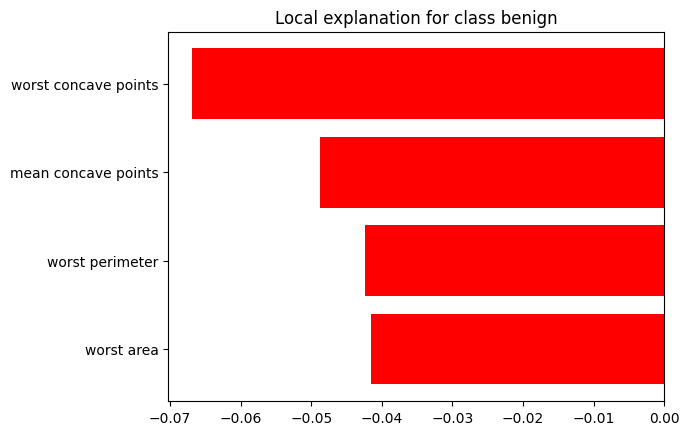

In [20]:
#variable level contribution
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)

In [21]:
pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

,Feature,Contribution
0,worst concave points,-0.066883
1,mean concave points,-0.048775
2,worst perimeter,-0.042389
3,worst area,-0.041482


In [22]:
X_test.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

## SHAP

In [23]:
# https://safjan.com/kernelshap-treeshap-two-most-popular-variations-of-the-shap-method/
# https://www.kdnuggets.com/2023/08/shap-values-model-interpretability-machine-learning.html

In [24]:
import shap
shap.plots.initjs()

In [25]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [26]:
shap_values[1].shape, X_test.shape

((456, 30), (456, 30))

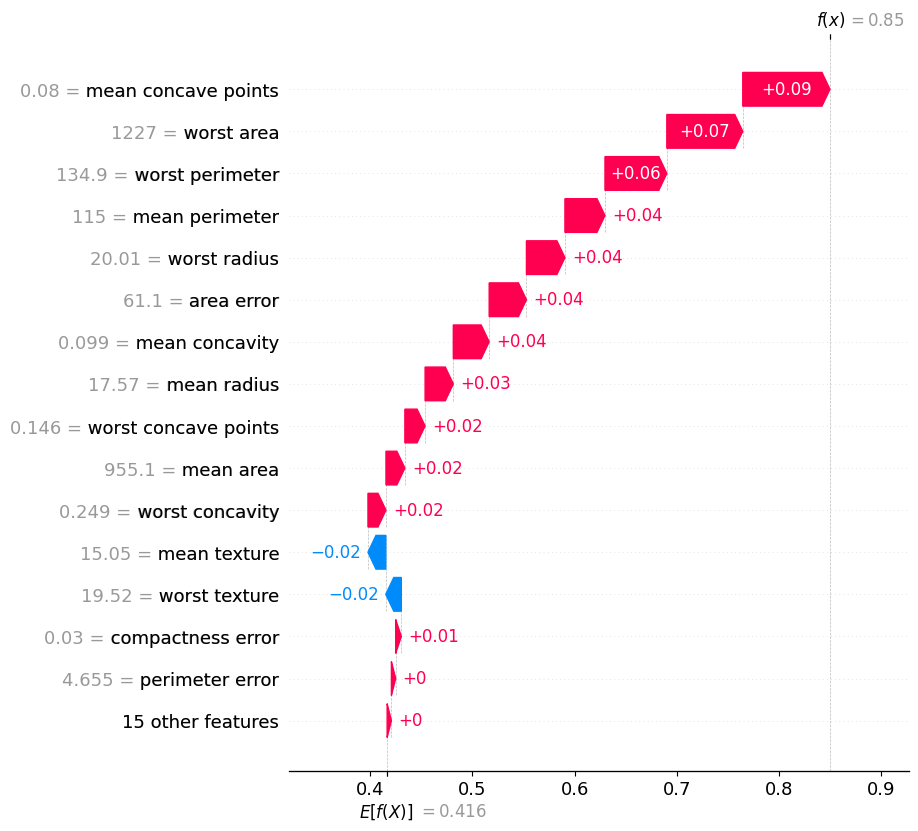

In [27]:
# https://github.com/shap/shap/issues/3172
exp = explainer(X_test)
output_to_explain = 0
shap.plots.waterfall(exp[id_to_explain,:,output_to_explain], max_display=16)
# shap.plots.waterfall(exp[id_to_explain,:,1], max_display=6)

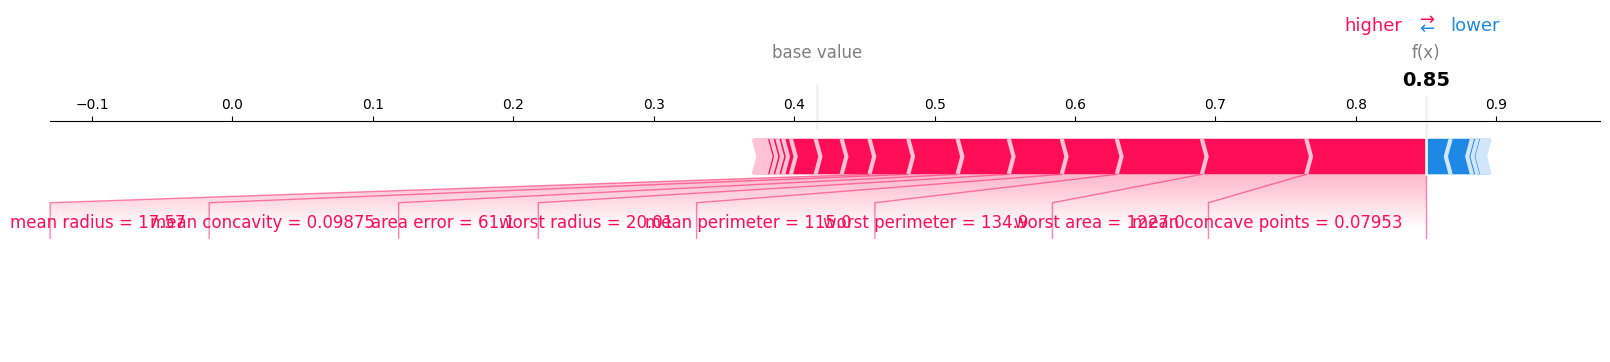

In [28]:
shap.plots.force(explainer.expected_value[0], shap_values[0][id_to_explain,:], X_test.iloc[id_to_explain, :], matplotlib = True)

In [30]:
# https://www.youtube.com/watch?v=L8_sVRhBDLU&ab_channel=ADataOdyssey
shap.plots.force(explainer.expected_value[0], shap_values[0][id_to_explain:id_to_explain+10], feature_names=feature_names)
# shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.columns)

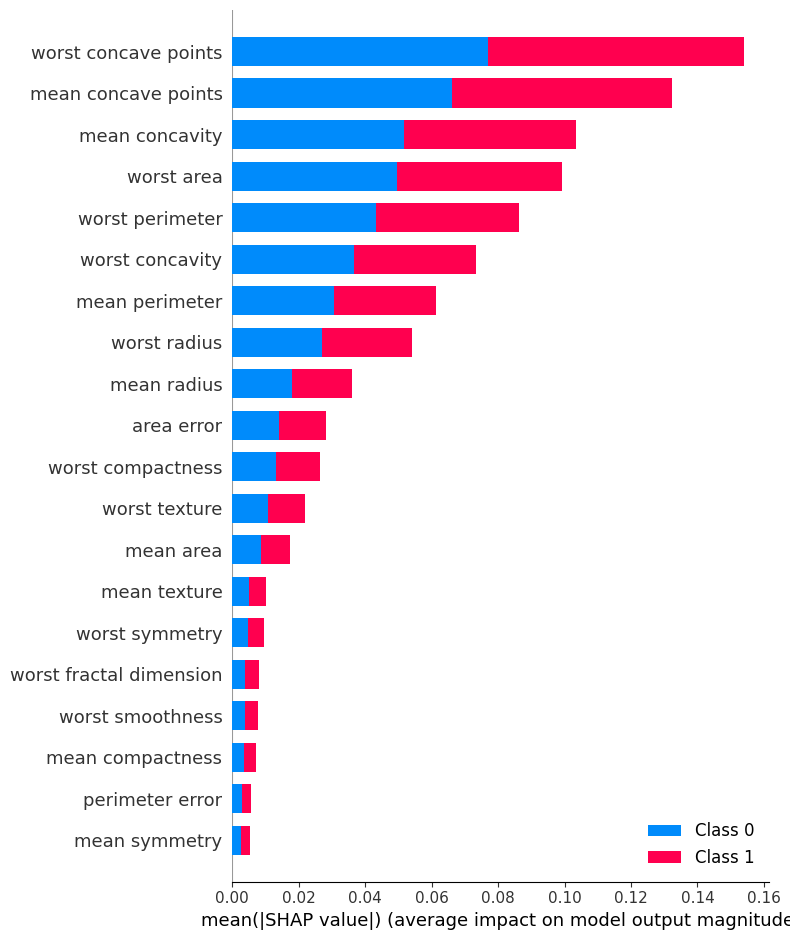

In [31]:
shap.summary_plot(shap_values, X_test)